<a href="https://colab.research.google.com/github/ReemaHariry/Transformers/blob/main/spamORham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [56]:
!pip install transformers datasets evaluate -q


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer ,AutoModelForSequenceClassification , TrainingArguments ,Trainer
import evaluate
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


ModuleNotFoundError: No module named 'evaluate'

# Analysis

In [2]:
dataset = load_dataset("FredZhang7/all-scam-spam")
print(f"Dataset structure: {dataset}")

df = dataset["train"].to_pandas()
df.head(10)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

junkmail_dataset.csv:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42619 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'is_spam'],
        num_rows: 42619
    })
})


,text,is_spam
0,Re: New Sequences Window\n\n Date: W...,0
1,[zzzzteana] RE: Alexander\n\nMartin A posted:\...,0
2,[zzzzteana] Moscow bomber\n\nMan Threatens Exp...,0
3,[IRR] Klez: The Virus That Won't Die\n\nKlez:...,0
4,Re: [zzzzteana] Nothing like mama used to make...,0
5,Re: [zzzzteana] Nothing like mama used to make...,0
6,[zzzzteana] Playboy wants to go out with a ban...,0
7,Re: [zzzzteana] Nothing like mama used to make...,0
8,[zzzzteana] Meaningful sentences\n\nThe Scotsm...,0
9,[SAtalk] SA CGI Configurator Scripts\n\nI have...,0


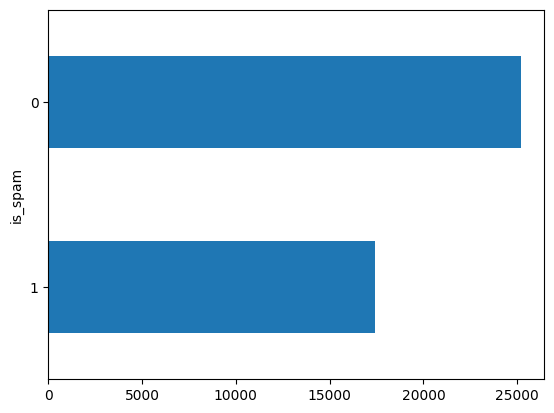

In [59]:
#is_spam=1 means spam and is_spam=0 means ham.
label_counts = df['is_spam'].value_counts(ascending=True)
label_counts.plot.barh()
plt.show()


# Words_embedding --> Tokenize

In [60]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

# models

In [61]:
tiny_model = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(tiny_model)

print("Vocab size:", tokenizer.vocab_size)
print("Max length:", tokenizer.model_max_length)


Vocab size: 30522
Max length: 1000000000000000019884624838656


## Split the dataset to Train/Test


In [62]:
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'is_spam'],
        num_rows: 38357
    })
    test: Dataset({
        features: ['text', 'is_spam'],
        num_rows: 4262
    })
})


In [63]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/38357 [00:00<?, ? examples/s]

Map:   0%|          | 0/4262 [00:00<?, ? examples/s]

In [64]:
tokenized_dataset = tokenized_dataset.rename_column("is_spam", "labels")

## Fine Tuning

In [65]:
tiny_model = AutoModelForSequenceClassification.from_pretrained(
    tiny_model,
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [67]:
training_args = TrainingArguments(
    output_dir="./results",          # where checkpoints are saved
    eval_strategy="epoch",     # evaluate after each epoch
    save_strategy="epoch",           # save model after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,              # for first test, can increase later
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [68]:
trainer = Trainer(
    model=tiny_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1843230211.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [69]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [71]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.177700,0.147430,0.951431
2,0.150600,0.132575,0.958001


TrainOutput(global_step=4796, training_loss=0.2088122334054751, metrics={'train_runtime': 203.2087, 'train_samples_per_second': 377.513, 'train_steps_per_second': 23.601, 'total_flos': 97464142786560.0, 'train_loss': 0.2088122334054751, 'epoch': 2.0})